# RECOMMENDER SYSTEMS

This notebook will help you to create an **easy-to-replicate** Movie Recommendation System. You will write a movie name and the system will recommend several movies accordingly. I will divide this study into 3 sections:
1. Exploring and preparing data
2. Creating the initial recommender system using item-based collaborative filtering
3. Enhancing the recommender system by using movie overviews and movie tags


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors

## Part 1. EDA and Data Preparation

In [28]:
df = pd. read_csv('ratings.csv')
df.drop(['timestamp'], axis=1, inplace=True)
df['movieId'] = df['movieId'].astype(int, errors='ignore')

print(f'Unique Values for Each Column: \n{df.apply(pd.Series.nunique)} \n')
print(f'There are {len(df)} ratings in total \n')
df.head(2)


Unique Values for Each Column: 
userId     270896
movieId     45115
rating         10
dtype: int64 

There are 26024289 ratings in total 



,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5


We can see that the dataset is large; contains 26m ratings from 270k users.
Now, we can check the distribution of ratings to see if the rating distribution is normal.

Mean value is 3.53


<Axes: title={'center': 'Rating Frequency Chart'}, ylabel='Frequency'>

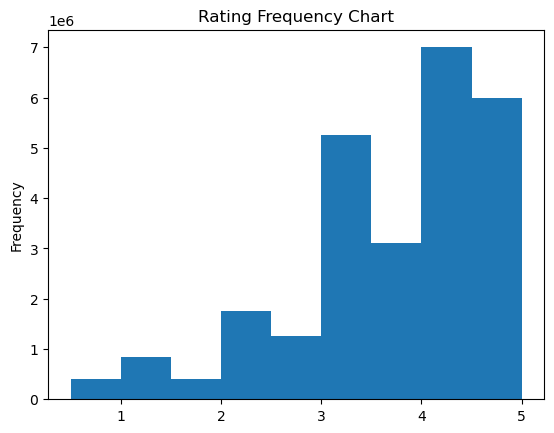

In [29]:
df_mean = df['rating'].mean()
print(f'Mean value is {df_mean:.2f}')
df['rating'].plot(kind='hist', bins=9, title='Rating Frequency Chart')

The answer is no. Mean rating is 3.53 and we can see that people have tendency to rate 4.5 and 5.0 a lot. 

For the next step, we need to combine other data files (movies_metadata.csv, links.csv, keywords.csv). Each of them contains data that we will be using later on. 

Please note that "id" column in movies_metadata.csv and keywords.csv are not movie_id, but in fact tmdbId. It took me some time to realize that during merging files.

In [30]:
df_meta = pd.read_csv('movies_metadata.csv',
                      on_bad_lines='skip', low_memory=False)

df_meta.rename(columns={'id': 'tmdbId'}, inplace=True)
df_meta["tmdbId"] =pd.to_numeric(df_meta['tmdbId'], errors='coerce',downcast="integer")

In [31]:
#Taking movieId and tmdbId(id column at metadata) from links file
df_links = pd.read_csv('links.csv',
                      on_bad_lines='skip', low_memory=False)
df_links = df_links[['movieId', 'tmdbId']]
df_links.drop_duplicates(subset=['tmdbId'], inplace=True)

In [32]:
#Taking keywords from keywords file
df_keywords = pd.read_csv('keywords.csv',
                      on_bad_lines='skip')
df_keywords.rename(columns={'id': 'tmdbId'}, inplace=True)

In [33]:
#Merging DataFrames, keeping only movieId and title, removing bad lines
df_meta = pd.merge(df_links, df_meta, how='inner', on='tmdbId')
df_meta["movieId"] =pd.to_numeric(df_meta['movieId'], errors='coerce',downcast="integer")
df_meta.dropna(subset=["movieId"],inplace=True)
df_meta = pd.merge(df_meta, df_keywords, how='left', on='tmdbId')
df_meta.head(2)

,movieId,tmdbId,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords
0,1,862.0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,2,8844.0,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."


Now we have a DataFrame named "df_meta" that contains all data regarding movies, combined. 
Description of important columns:

* movieId: the unique id for each movie in this dataset

* budget - the budget of the movie, contains many "0" values - not reliable

* original_language - the language that the movie was made

* original_title - the original name of the movie

* overview - a short summary of the movie

* revenue - worldwide generated revenue in USD

* runtime - the length of the movie in minutes

* votecount - the total amount of votes that the movie received in this dataset

* keywords - tags for the movie, each tag also has an id

In [34]:
df_meta = df_meta[['movieId', 'original_language', 'original_title', 'overview', 'revenue', 'runtime', 'keywords']]
df = pd.merge(df, df_meta, on="movieId",how="inner")
print(f'{df.info()}\n')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26025228 entries, 0 to 26025227
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   userId             int64  
 1   movieId            int32  
 2   rating             float64
 3   original_language  object 
 4   original_title     object 
 5   overview           object 
 6   revenue            float64
 7   runtime            float64
 8   keywords           object 
dtypes: float64(3), int32(1), int64(1), object(4)
memory usage: 1.8+ GB
None



Now we have a huge DataFrame named "df" that contains all the data, inc. ratings. This approach is not the efficient one, but our resources can handle 26m entries with ease.

Now, I will eliminate some users and some movies. The reason is:
1. I don't want a "too sparse rating matrix". Therefore, users that rated only several movies and unpopular movies will be eliminated.
2. I only want movies with original language "English". 

In [35]:
df.drop(df[df['original_language'] != 'en'].index, inplace=True)

user_groupby = pd.Series(Counter(df['userId']))
freq_voters = user_groupby.loc[lambda x : x > 150]
print(f'In total, we will consider {freq_voters.size} voters as they voted for more than 150 movies')

movies_groupby = pd.Series(Counter(df['movieId']))
popular_movies = movies_groupby.loc[lambda x : x > 1000]
print(f'In total, we will consider {popular_movies.size} movies as they are voted by  more than 1000 users')

freq_voters = np.array(freq_voters.index)
popular_movies = np.array(popular_movies.index)

In total, we will consider 41419 voters as they voted for more than 150 movies
In total, we will consider 3476 movies as they are voted by  more than 1000 users


In [36]:
df = df[df['userId'].isin(freq_voters)]
df = df[df['movieId'].isin(popular_movies)]
df.dropna(inplace=True)
print(f'{df.info()}\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14315076 entries, 1 to 25344669
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   userId             int64  
 1   movieId            int32  
 2   rating             float64
 3   original_language  object 
 4   original_title     object 
 5   overview           object 
 6   revenue            float64
 7   runtime            float64
 8   keywords           object 
dtypes: float64(3), int32(1), int64(1), object(4)
memory usage: 1.0+ GB
None



Even though I dropped non-English movies, movies that are rated less than 1,000 times and users that rated less than 150 movies; there is still more than 14m datapoints and it's more than enough to create a decent recommender system.

Now our dataframe is totaly ready; we can complete our recommender system only by using parts of our dataframe.

## Part 2. Collaborative Filtering

First, we will create a rating matrix, rows are users' ratings and columns are movies. DataFrame's pivot_table method is a shortcut for this task.
We can expect a sparse matrix.

In [37]:
df_matrix =  df[['userId', 'original_title', 'rating']]
rating_matrix = df_matrix.pivot_table(index='original_title',  columns='userId', values='rating')
rating_matrix.info()
print(f'{rating_matrix.info()}\n')


<class 'pandas.core.frame.DataFrame'>
Index: 3417 entries, (500) Days of Summer to Æon Flux
Columns: 41419 entries, 11 to 270896
dtypes: float64(41419)
memory usage: 1.1+ GB
<class 'pandas.core.frame.DataFrame'>
Index: 3417 entries, (500) Days of Summer to Æon Flux
Columns: 41419 entries, 11 to 270896
dtypes: float64(41419)
memory usage: 1.1+ GB
None



We need to fill each cell, cannot keep Nan.

There are several alternative ways for this, I have chosen filling with 0 and keep a sparse matrix form. In other instances, such as reducing dimensionality using SVD, filling with row averages also yield good result.

In [38]:
rating_matrix_filled = rating_matrix.apply(lambda row: row.fillna(0), axis=1)
rating_matrix_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3417 entries, (500) Days of Summer to Æon Flux
Columns: 41419 entries, 11 to 270896
dtypes: float64(41419)
memory usage: 1.1+ GB


As we have a large dataset, we can use a flexible model. I will use KNN, which is highly flexible. Additionly, KNN is non-parametric (checking item similarity by checking distance between them in N-dimensional space) so I do not need to make assumptions about the distribution.

There are different distance metrics for KNN. I tried ecludian distance, but cosine similarity is working slightly better.

In [39]:
#Training KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=2)
knn.fit(rating_matrix_filled)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=2, n_neighbors=20)

In [40]:
def movieRecommender(movie_name, knn, matrix):
  try:
    dist, idx = knn.kneighbors(matrix.loc[movie_name].values.reshape(1,-1),n_neighbors=20)
    print(f'For your selection of {movie_name}, I will recommend \n')
    for i in range(1, len(dist.flatten())):
      movie_name = matrix.index[idx.flatten()[i]]
      print(f'{i}- {movie_name}, distance is {dist.flatten()[i]:.3f}')
  except:
    print(f'The movie {movie_name} is not in our database. \n Please note that our database contains only popular movies up until mid 2017.')

Now it's time to try our recommender system with an example movie:

In [41]:
movieRecommender('Ace Ventura: Pet Detective', knn, rating_matrix_filled)

For your selection of Ace Ventura: Pet Detective, I will recommend 

1- Dumb and Dumber, distance is 0.268
2- Ace Ventura: When Nature Calls, distance is 0.289
3- The Mask, distance is 0.309
4- Home Alone, distance is 0.359
5- Forrest Gump, distance is 0.360
6- Jurassic Park, distance is 0.363
7- Mrs. Doubtfire, distance is 0.363
8- Independence Day, distance is 0.373
9- Speed, distance is 0.390
10- Mission: Impossible, distance is 0.394
11- Terminator 2: Judgment Day, distance is 0.395
12- Batman, distance is 0.396
13- Pulp Fiction, distance is 0.397
14- Batman Forever, distance is 0.400
15- Austin Powers: The Spy Who Shagged Me, distance is 0.401
16- Back to the Future, distance is 0.402
17- Austin Powers: International Man of Mystery, distance is 0.403
18- True Lies, distance is 0.404
19- Liar Liar, distance is 0.407


In [42]:
movieRecommender('Batman Begins', knn, rating_matrix_filled)

For your selection of Batman Begins, I will recommend 

1- The Dark Knight, distance is 0.234
2- The Lord of the Rings: The Return of the King, distance is 0.261
3- The Lord of the Rings: The Two Towers, distance is 0.282
4- V for Vendetta, distance is 0.287
5- The Lord of the Rings: The Fellowship of the Ring, distance is 0.294
6- The Incredibles, distance is 0.298
7- Pirates of the Caribbean: The Curse of the Black Pearl, distance is 0.299
8- Sin City, distance is 0.300
9- Iron Man, distance is 0.301
10- Kill Bill: Vol. 1, distance is 0.312
11- Casino Royale, distance is 0.312
12- The Bourne Identity, distance is 0.314
13- Spider-Man 2, distance is 0.320
14- Kill Bill: Vol. 2, distance is 0.324
15- Fight Club, distance is 0.328
16- Spider-Man, distance is 0.329
17- Star Wars: Episode III - Revenge of the Sith, distance is 0.333
18- The Matrix, distance is 0.334
19- The Prestige, distance is 0.334


Our initial recommender system is working OK. I like "Ace Ventura" and I also like majority of recommendations listed for that movie.

However, recommendations for "Batman Begins" is weird. There are 3 LOTR movies in top 5. Yes,LOTR series is great, but it's not very similar to Nolan's Batman triology. We need to improve results by eliminating some recommendations that are not great by using genre/overview data.

## Part 3. Enhanching our Recommender

At the last part, we will try to improve the recommender system by eliminating some recommendations by utilizing the movie overview and the genre data.

First, we need to see how similar movie overviews are. But it requires converting sentences to vectors. Luckily, sentence embedding is designed for this task and there are many useful libraries that can do it for us. sentence_transformers library is one of them.


In [43]:
pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [44]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [45]:
def movieRecommenderEnhanced(movie_name, knn, matrix):
  recommendation_list = [movie_name]
  distances = [1]
  try:
    #Calculating distance between movies
    dist, idx = knn.kneighbors(matrix.loc[movie_name].values.reshape(1,-1),n_neighbors=20)
    for i in range(1, len(dist.flatten())):
      movie_name = matrix.index[idx.flatten()[i]]
      recommendation_list.append(movie_name)
      distance = dist.flatten()[i]
      distances.append(distance)
  except:
    print(f'The movie {movie_name} is not in our database. \n Please note that our database contains only popular movies up until mid 2017.')

  overview_embeddings = []
  similarities = []
  for movie in recommendation_list:
    overview = df_meta[df_meta['original_title'] == movie]['overview'].values[0]
    embedding = model.encode(overview)
    overview_embeddings.append(embedding)
    cosine_scores = util.cos_sim(overview_embeddings[0], embedding)
    similarities.append(cosine_scores.item())

  print(f'For your selection of {recommendation_list[0]}, I will recommend \n')
  counter = 1
  for i in range(1 , len(recommendation_list)):
    #Eliminating movies that their cosine similarity is lower than 0.2
    if similarities[i] > 0.2:
      print(f'{counter}- {recommendation_list[i]} and distance is {distances[i]:.3f}')
      counter += 1

Our system now takes movie overview as input and transform it to word embedding (a vector representing the overview). We do not recommend movies that has less than 0.2 cosine similarity to the movie we asked for recommendations.

Please note that cosine similarity results are between 0.0 and 1.0. Also, we cannot expect large similarity scores between movies. 0.4-0.5 can be considered extremely high.

In [46]:
movieRecommenderEnhanced('Batman Begins', knn, rating_matrix_filled)

For your selection of Batman Begins, I will recommend 

1- The Dark Knight and distance is 0.234
2- V for Vendetta and distance is 0.287
3- The Incredibles and distance is 0.298
4- Pirates of the Caribbean: The Curse of the Black Pearl and distance is 0.299
5- Sin City and distance is 0.300
6- Iron Man and distance is 0.301
7- Kill Bill: Vol. 1 and distance is 0.312
8- The Bourne Identity and distance is 0.314
9- Spider-Man 2 and distance is 0.320
10- Kill Bill: Vol. 2 and distance is 0.324
11- Fight Club and distance is 0.328
12- Spider-Man and distance is 0.329
13- The Matrix and distance is 0.334


We have some improvements. Our system no longer recommends LOTR triology for 'Batman Begins' movie. Although LOTR is a great movie, it has limited similarities with Nolan's Batman Begins movie. Yet, we can improve more by utilizing movie genres.

At the next step, we will combine all movie tags to create a single string and look at embedding of that string. Later, we will eliminate some recommendations accordingly.

In [47]:
def movieRecommenderEnhanced(movie_name, knn, matrix):
  recommendation_list = [movie_name]
  overview_distances = [1]
  try:
    dist, idx = knn.kneighbors(matrix.loc[movie_name].values.reshape(1,-1),n_neighbors=20)
    for i in range(1, len(dist.flatten())):
      movie_name = matrix.index[idx.flatten()[i]]
      recommendation_list.append(movie_name)
      distance = dist.flatten()[i]
      overview_distances.append(distance)
  except:
    print(f'The movie {movie_name} is not in our database. \n Please note that our database contains only popular movies up until mid 2017.')

  overview_embeddings = []
  overview_similarities = []
  for movie in recommendation_list:
    overview = df_meta[df_meta['original_title'] == movie]['overview'].values[0]
    embedding = model.encode(overview)
    overview_embeddings.append(embedding)
    cosine_scores = util.cos_sim(overview_embeddings[0], embedding)
    overview_similarities.append(cosine_scores.item())

  keyword_embeddings = []
  keyword_similarities = []
  for movie in recommendation_list:
    #Extracting keywords from the keywords column
    #Which is not in proper JSON format
    keywords = list(df_meta[df_meta['original_title'] == movie]['keywords'].values[0].split(","))
    tags = []
    for tag in keywords:
      if tag.startswith(" 'name"):
        tags.append(tag[10:-2])
    tags[-1] = tags[-1][:-1]

    combined_tags = " ".join(tags)
    embedding = model.encode(combined_tags)
    keyword_embeddings.append(embedding)
    cosine_scores = util.cos_sim(keyword_embeddings[0], embedding)
    keyword_similarities.append(cosine_scores.item())


  print(f'For your selection of {recommendation_list[0]}, I will recommend \n')
  counter = 1
  for i in range(1 , len(recommendation_list)):
    if overview_similarities[i] > 0.2 and keyword_similarities[i] > 0.3:
      print(f'{counter}- {recommendation_list[i]} and distance is {overview_distances[i]:.3f}')
      counter += 1

In [48]:
movieRecommenderEnhanced('Batman Begins', knn, rating_matrix_filled)

For your selection of Batman Begins, I will recommend 

1- The Dark Knight and distance is 0.234
2- V for Vendetta and distance is 0.287
3- The Incredibles and distance is 0.298
4- Pirates of the Caribbean: The Curse of the Black Pearl and distance is 0.299
5- Sin City and distance is 0.300
6- Iron Man and distance is 0.301
7- Kill Bill: Vol. 1 and distance is 0.312
8- Spider-Man 2 and distance is 0.320
9- Kill Bill: Vol. 2 and distance is 0.324
10- Fight Club and distance is 0.328
11- Spider-Man and distance is 0.329
12- The Matrix and distance is 0.334


This step eliminated 'The Bourne Identity' movie from the recommendations. I would be happy if it would eliminate 'The Incredibles' as well, but our recommender system seems fine. 

In [49]:
movieRecommenderEnhanced('The Matrix Reloaded', knn, rating_matrix_filled)

For your selection of The Matrix Reloaded, I will recommend 

1- The Matrix Revolutions and distance is 0.197
2- The Matrix and distance is 0.313
3- Minority Report and distance is 0.316
4- Star Wars: Episode II - Attack of the Clones and distance is 0.341
5- Batman Begins and distance is 0.370


# Conclusion

Item-based colloborative filtering, enhanced with "overview/tags embedding closeness filtering" (eliminated recommendations from unrelated genres, even if many users liked them both) yielded satisfactory results for our study. Recommended movies are reasonably well-selected for given titles.

As a note: we used a subset of the total available data in our study. This study can be enhanced using cast data, runtime (some people may have preference over shorter or longer movies), average vote rating (some people may only prefer high-rated movies), and so on.